# Linear Regression from scratch
Implementing linear regression using only numpy

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
np.random.seed(0)

## Cost function and its derivative
Cost represents a cost function of the form `y = b + w1*x1 + w2*x2 ... wn*xn`  
But to vectorize the computation, we take X as the whole training sample  
One row in X has one row of dataset.  
Last column of each row is set to 1 to account for bias

In [2]:
class Cost:
    
    def __init__(self, X_train):
        # Make X as [X 1] for vectorization
        self.rows = X_train.shape[0]
        self.cols = X_train.shape[1] + 1
        self.X = np.concatenate([np.ones((self.rows, 1)), X_train], axis=1)
        #print(f"X shape: {self.X.shape}")
        #print(f"Y self: {self.Y.shape}")
    
    
    def compute(self, W):
        assert W.shape == (1, self.cols)
        # y_hat = SUM(wi*xi)
        # For whole train data, we do element-wise multiplication
        # W is implicitly broadcasted to match X shape
        # Summation over column axis computes the value of cost function for each data sample
        Y_hat = (self.X * W).sum(axis=1).reshape((1, self.rows))
        #print(f"Y_hat shape: {Y_hat.shape}")
        return Y_hat
    
    
    def derivative(self, Y, W):
        assert W.shape == (1, self.cols)
        assert Y.shape == (1, self.rows)
        # (1/N) * 2*xi*(yi - (wi*xi))
        WX = (self.X * self.X * W).T
        #print(f"WX shape: {WX.shape}")
        XY = Y * self.X.T
        #print(f"XY shape: {XY.shape}")
        dY_wrt_dW = -2 * (XY - WX)
        #print(f"XY-WX shape: {dY_wrt_dW.shape}")
        dY_wrt_dW = dY_wrt_dW.sum(axis=1).reshape((1, self.cols)) / self.rows
        #print(f"dW shape: {dY_wrt_dW.shape}")
        return dY_wrt_dW
        

## Gradient Descent
A generalized gradient descent that takes a Cost and updates weights using cost.derivative()  
Weights are initialized to random values

In [3]:
class GradientDescent:
    
    def __init__(self, learning_rate=1e-6, epochs=2, log_interval=1, save_data=False):
        self.alpha = learning_rate
        self.epochs = epochs
        self.log_interval = log_interval
        self.save_data = save_data
    
    
    def update_weights(self, cost, Y, W):
        W = W - self.alpha * cost.derivative(Y, W)
        return W
    
    def optimize(self, cost, Y):
        W = np.random.randn(cost.cols).reshape((1, cost.cols))
        if self.save_data:
            self.costs = []
            self.losses = []
            self.weights = []
        for i in range(self.epochs):
                W = self.update_weights(cost, Y, W)
                if self.save_data:
                    Y_hat = cost.compute(W)
                    self.costs.append(Y_hat)
                    self.losses.append(self.loss(Y, Y_hat))
                    self.weights.append(W)
        return W
    
         
    def loss(self, Y, Y_hat):
        sq_diff = (Y - Y_hat) * (Y - Y_hat)
        l = sq_diff.mean()**0.5
        return l
    

## Multi-variate Linear Regression
A generalized implementation of linear regression with any arbitrary Cost

In [4]:
class MyLinearRegression:
    
    def __init__(self, CostFunc=Cost, normalize=False):
        self.Cost = CostFunc
        self.normalize = normalize
        self.optimizer = None
        self.mu = None
        self.div = None
        
        
    def set_optimizer(self, optimizer):
        self.optimizer = optimizer
    
      
    def train(self, X_train, Y_train, logInterval=1):
        assert self.optimizer != None
        
        if self.normalize:
            self.compute_normalization_params(X_train)
            X_train = self.perform_normalization(X_train)
            
        cost = self.Cost(X_train)
        Y_train = Y_train.reshape((1, cost.rows))
                
        self.W = self.optimizer.optimize(cost, Y_train)
    
    
    def compute_normalization_params(self, X):
        self.mu = X.mean(axis=0)
        self.div = X.shape[0]
        X = (X - self.mu) / self.div
        return X
    
    
    def perform_normalization(self, X):
        X = (X - self.mu) / self.div
        return X
    
    
    def test(self, X_test, Y_test):
        if self.normalize:
            X_test = self.perform_normalization(X_test)
        c = self.Cost(X_test)
        Y_hat = c.compute(self.W)
        l = self.optimizer.loss(Y_test, Y_hat)
        return l
    
    
    def predict(self, x):
        if self.normalize:
            x = self.perform_normalization(x)
        y = self.Cost(np.array([x])).compute(self.W)[0,0]
        return y
        
    
    def getWeights():
        return self.W
    

## K-fold cross validation
Helper class for performing k-fold cross validation given any model

In [5]:
class CrossValidator:
    
    def __init__(self, k=5):
        self.k = k
    
    
    def shuffle_together(self, X, Y, seed=-1):
        # Source: https://stackoverflow.com/a/51526109/6699069
        if seed < 0:
            seed = np.random.randint(0, 2**(32 - 1) - 1)
        rstate = np.random.RandomState(seed)
        rstate.shuffle(X)
        rstate = np.random.RandomState(seed)
        rstate.shuffle(Y)
        
    def k_split(self, X, Y):
        folds = []
        fold_size = int(np.ceil(X.shape[0]/self.k))
        print(f"Creating {self.k} folds of {fold_size} samples in each")
        for start in range(0, X.shape[0], fold_size):
            folds.append([X[start:start+fold_size],
                          Y[start:start+fold_size]])
        assert len(folds) == self.k
        return folds
    
    def validate(self, X, Y, model, shuffle_seed=-1):
        self.shuffle_together(X, Y, shuffle_seed)
        folds = self.k_split(X, Y)
        loss = []
        for i in range(self.k):
            # Pick k-1 folds for training
            X_train = np.concatenate([f[0] for k, f in enumerate(folds) if k!=i], axis=0)
            Y_train = np.concatenate([f[1] for k, f in enumerate(folds) if k!=i], axis=0)
            # Pick i-th fold for testing
            X_test = folds[i][0]
            Y_test = folds[i][1]
            print(f"Training on all folds except fold[{i}]")
            # Train on k-1 folds
            model.train(X_train, Y_train)
            # Test on i-th fold
            l = model.test(X_test, Y_test)
            print(f"Test loss = {l:.4f}")
            loss.append(l)
        cv_loss = np.array(loss).mean()
        print(f"Average test loss: {cv_loss:.4f}")
        return cv_loss
        

## Setup data

In [6]:
df = pd.read_csv('../datasets/student_data.csv')
df.head()

,Rank,Sem 1,Sem 2,Sem 3,Sem 4,Sem 5,Sem 6,Sem 7,Travel,Hobby,Study,Room,comp_exam,High_studies,placement,extra_curr,JEE
0,1,9.51,9.09,9.00,10.00,9.87,9.58,9.09,39,0,5,0,1,1,1,0,62
1,2,9.30,9.13,9.00,9.67,9.48,9.50,9.13,121,0,6,1,1,0,0,1,65
2,3,9.28,9.09,8.95,9.86,9.57,9.15,9.09,3,0,6,1,0,1,1,0,32
3,4,9.24,8.91,9.00,9.71,9.35,9.31,8.91,61,1,1,0,1,1,0,1,98
4,5,9.21,9.09,8.91,9.71,9.61,9.23,9.09,77,1,0,1,1,0,0,0,57


In [7]:
features = ['Sem 1', 'Sem 2', 'Sem 3','Sem 4','Sem 5','Sem 6', 'JEE', 'Travel','Hobby','Study', 'Room', \
           'comp_exam', 'High_studies', 'placement', 'extra_curr']
labels = ['Sem 7']

## Visualization
Visualize relationship between features and labels

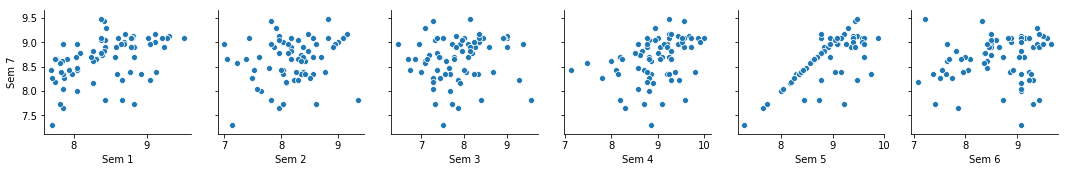

In [8]:
sb.pairplot(df, x_vars=features[:6], y_vars=labels, palette='husl')

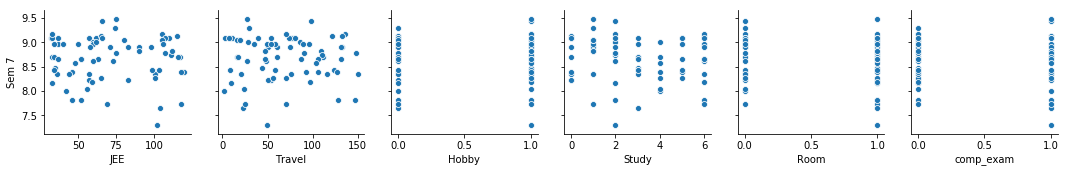

In [9]:
sb.pairplot(df, x_vars=features[6:12], y_vars=labels, palette='husl')

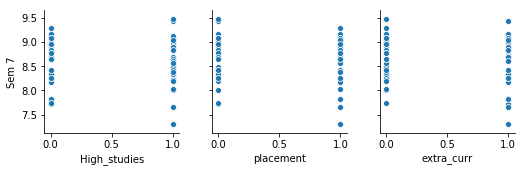

In [10]:
sb.pairplot(df, x_vars=features[12:], y_vars=labels, palette='husl')

## Prepare data for train and test

In [11]:
X = df[features].values # extract numpy array from DataFrame
Y = df[labels].values

In [12]:
def shuffle_and_split(A,B, ratio=0.5):
    seed = np.random.randint(0, 2**(32 - 1) - 1)
    rstate = np.random.RandomState(seed)
    rstate.shuffle(A)
    rstate = np.random.RandomState(seed)
    rstate.shuffle(B)
    pivot = int(np.ceil(A.shape[0]*ratio))
    return A[:pivot], B[:pivot], A[pivot:], B[pivot:]

In [13]:
np.random.seed(0)
X_train, Y_train, X_test, Y_test = shuffle_and_split(X,Y, ratio=0.75)

### Helpers for visualizing training

In [14]:
def plot_loss(loss_list):
    df = pd.DataFrame({'RMSE': loss_list, 'Epochs':list(range(len(loss_list)))})
    return sb.lineplot(data=df, y='RMSE', x='Epochs', sort=False)

## Training without normalization

In [15]:
model = MyLinearRegression(Cost, normalize=False)
grad_descent = GradientDescent(learning_rate=1e-4, epochs=1000, log_interval=100, save_data=True)
model.set_optimizer(grad_descent)
model.train(X_train, Y_train)

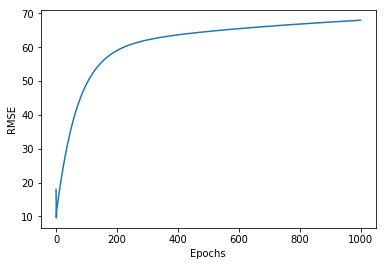

In [16]:
plot_loss(grad_descent.losses)

Loss is huge. Gradient off-shoots even with a slow learning rate of 0.0001. If learning rate is increased further, loss will tend to infinity

## Training with mean normalization
All the above classes will be used now. Each class is made from scratch using only numpy.

In [17]:
model = MyLinearRegression(Cost, normalize=True)
grad_descent = GradientDescent(learning_rate=0.5, epochs=1000, log_interval=100, save_data=True)
model.set_optimizer(grad_descent)
model.train(X_train, Y_train)

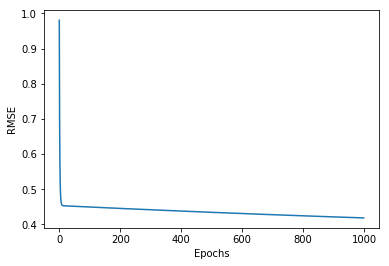

In [18]:
plot_loss(grad_descent.losses)

Successfull convergence even with fast learning rate of 0.5. We can expect increase in accuracy with more epochs

In [19]:
train_loss = model.test(X_train, Y_train)
test_loss = model.test(X_test, Y_test)
print(f'Train loss: {train_loss:.4f}\nTest loss: {test_loss:.4f}')
print(f"Prediction: {model.predict(X_test[0]):.2f}\nActual: {Y_test[0,0]}")

Train loss: 0.4833
Test loss: 0.4012
Prediction: 8.58
Actual: 8.43


## Cross validation

In [20]:
validator = CrossValidator(k=4)
validator.validate(X, Y, model, shuffle_seed=0)

Creating 4 folds of 18 samples in each
Training on all folds except fold[0]
Test loss = 0.3757
Training on all folds except fold[1]
Test loss = 0.4805
Training on all folds except fold[2]
Test loss = 0.5163
Training on all folds except fold[3]
Test loss = 0.4841
Average test loss: 0.4642


0.4641696891376864